# Watermark

A watermark is an image, overlay, or text that's placed over a digital asset. Usually, the image will be monochromatic and transparent, to enable others to still view the asset.

## Imports

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load & Show Images

In [47]:
def load_image(path,size = (256,256)):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, size)
    return img

def show_image(image):
    plt.imshow(image,cmap='gray')
    plt.show()

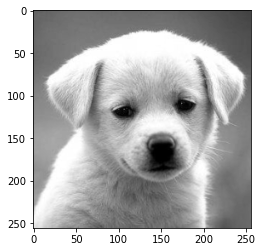

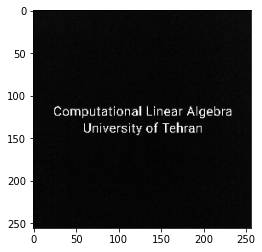

In [48]:
original_img = load_image("./images/dog.jpg")
watermark_img = load_image("./images/watermark1.jpeg")

show_image(original_img)
show_image(watermark_img)

## Implementation; Embedding:

In this part you should add watermark to the original image. You should implement the following algorithm.

1. Perform SVD on the original image (A matrix) and form the result as $USV^T$.

2. Add watermark (W matrix), muliplied by a coefficine K, to the SVs of the original matrix. (S matrix in the previous step)

3. Now, perform SVD again on matrix D.

4. Replace the matrix S in the first step, with the SVs of the previous step (the middle matrix in step 3) to get the watermarked image.

In [55]:
def encode_watermark(original_img, watermark_img, watermarked_coeff=0.7):
    u, s, v_t = np.linalg.svd(original_img)
    s = np.diag(s)
    
    D = np.add(s, np.multiply(watermarked_coeff, watermark_img))
    u_n, s_n, v_n_t = np.linalg.svd(D)
    watermarked_image = u @ np.diag(s_n) @ v_t
   
    return watermarked_image

In [56]:
def encode_watermark_matrixes(original_img, watermark_img, watermarked_coeff=0.7):
    u, s, v_t = np.linalg.svd(original_img)
    s = np.diag(s)
    
    D = np.add(s, np.multiply(watermarked_coeff, watermark_img))
    u_n, s_n, v_n_t = np.linalg.svd(D)
    s_n = u @ np.diag(s_n) @ v_t

    return u_n, s, v_n_t

Display the watermarked image.

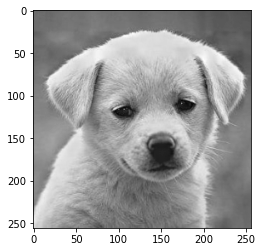

In [57]:
watermarked_img = encode_watermark(np.asarray(original_img), np.asarray(watermark_img), 0.7)

show_image(watermarked_img)


## Watermark Extraction:
The task in this part is to extract the watermarked image from a distorted one ($A^*_w$ matrix) and write the sentence that is written in the watermarked image. The matrix of singular values (S) from the original image, $U_w$, $V^T_w$, and the watermarked image are given to you.

1. Perform SVD on the distorted watermarked image ($A^*_w$ matrix) in the form of $U^* S^*_w V^{*T}$.

2. Compute the matrix that includes the watermark by $D^* = U_w S^*_w V^T_w$.

3. Compute the corrupted watermark by subtracting the matrix $S$ from $D^*$ and dividing the result by the coefficient of the watermark, $k$.


In [58]:
def get_watermark(watermarked_img, watermarked_u, s, watermarked_vt, watermarked_coeff):
    u, s_n, v_t = np.linalg.svd(watermarked_img)
    s_n = np.diag(s_n)
    D = watermarked_u @ s_n @ watermarked_vt
    watermark = np.multiply(D - s, 1 / watermarked_coeff)

    return watermark

Get the watermark logo and display it. Note that in this section we do not know the watermark coefficient. You have to run the previous cell's function for at least 5 different coefficients and compare the results.   

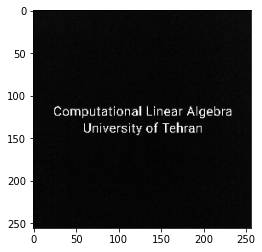

In [59]:
u_n, s , v_n_t = encode_watermark_matrixes(np.asarray(original_img), np.asarray(watermark_img), 0.7)

img = get_watermark(watermarked_img, u_n, s, v_n_t, 0.7)
show_image(img)

## Embed two watermarks in an image
We explain the procedure of our method in the following steps:
1. Perform the SVD on the original image and the two watermarks. Obtain $U \Sigma V^{T}$, $U_{1} \Sigma_{1} V_{1}^{T}$ and $U_{2} \Sigma_{2} V_{2}^{T}$.
2. Define $A_{1} = \Sigma_{1} V_{1}^{T}$ and $A_{2} = U_{2} \Sigma_{2}$. (We need these for the watermark extraction)
3. We set a watermarking coeffiecent $k$.
4. Set $U_{w} = U + k  U_{1}$ and $V_w^{T} = V^{T} + k  V_{1}^{T}$.
5. Generate the watermarked image as $W = U_{w} \Sigma V_w^{T}$.

In [60]:
def encode_multiple_watermark(original_img, watermark1_img, watermark2_img, watermarked_coeff=0.7):
    u, s, v_t = np.linalg.svd(original_img)
    s = np.diag(s)
    
    w1_u, s1, w1_v_t = np.linalg.svd(watermark1_img)
    s1 = np.diag(s1)

    w2_u, s2, w2_v_t = np.linalg.svd(watermark2_img)
    s2 = np.diag(s2)

    new_u = u + watermarked_coeff * w1_u
    new_v_t = v_t + watermarked_coeff * w2_v_t

    watermarked_image = new_u @ s @ new_v_t
   
    A1 = s1 @ w1_v_t
    A2 = w2_u @ s2

    return watermarked_image, A1, A2

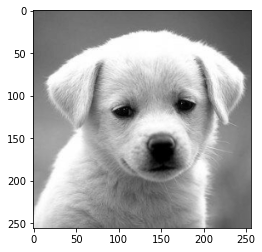

In [61]:
original_img = load_image("./images/dog.png")
watermark1_img = load_image("./images/watermark1.jpeg")
watermark2_img = load_image("./images/watermark2.jpeg")

watermarked_img , A1, A2= encode_multiple_watermark(original_img, watermark1_img, watermark2_img, 0.001)

show_image(watermarked_img)

## Extract the two watermarks
We obtain the watermarks by applying the reverse of the previous procedure we implemented for embedding them. (W)
1. Obtain first watermark by: $ W_{1} = (W ((S V^{T})^{-1} - U)) / k) A_1 $.
2. Obtain second watermark by: $ W_{2} = A_2 ((U\Sigma^{-1} W  - V^{T} ) / k) $.

In [62]:
def extract_multiple_watermark(original_img, watermarked_img, watermark1_matrix, watermark2_matrix, watermarked_coeff=0.7):
    u, s, v_t = np.linalg.svd(original_img)
    s = np.diag(s)

    watermark1 = ((watermarked_img @ (np.linalg.inv(s @ v_t)) - u) / watermarked_coeff) @ watermark1_matrix

    watermark2 = watermark2_matrix @ (((np.linalg.inv(u @ s) @ watermarked_img) - v_t) / watermarked_coeff)
    
    return watermark1, watermark2

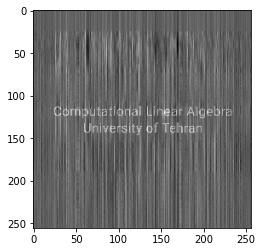

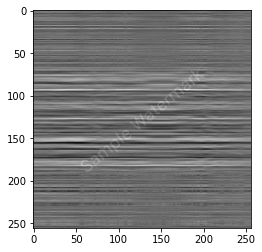

In [63]:
watermark1_img, watermark2_img = extract_multiple_watermark(original_img, watermarked_img, A1, A2, 0.001)

show_image(watermark1_img)
show_image(watermark2_img)

In [64]:
def dct_embedding(watermark_img, original_img):
    w, h = original_img.shape[:2]
    
    size = 2
    sig_size = 128
    Q = 10

    embed_pos = [(0, 0)]
    if w > 2 * sig_size * size:
        embed_pos.append((w - sig_size*size, 0))
    if h > 2 * sig_size * size:
        embed_pos.append((0, h - sig_size*size))
    if len(embed_pos) == 3:
        embed_pos.append((w - sig_size*size, h - sig_size*size))

    for x, y in embed_pos:
            for i in range(x, x + sig_size * size, size):
                for j in range(y, y + sig_size * size, size):
                    v = np.float32(original_img[i:i + size, j:j + size])
                    v = cv2.dct(v)
                    v[size-1, size-1] = Q * (watermark_img.flatten())[((i-x)//size) * sig_size + (j-y)//size]

                    v = cv2.idct(v)
                    maximum = max(v.flatten())
                    minimum = min(v.flatten())
                    if maximum > 255:
                        v = v - (maximum - 255)
                    if minimum < 0:
                        v = v - minimum
                    original_img[i:i+size, j:j+size] = v
    return original_img


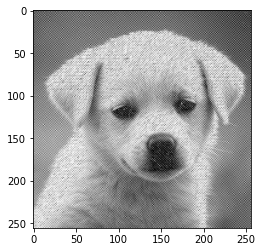

In [65]:
original_img = load_image("./images/dog.jpg")
watermark_img = load_image("./images/watermark1.jpeg")

watermarked_img = dct_embedding(watermark_img, original_img)
show_image(watermarked_img)

## References:
- MULTIPLE IMAGE WATERMARKING BASED ON SVD : IMPROVING CAPACITY AND IMPERCEPTIBILITY by Henri Bruno Razafindradina and colleagues ([link](https://www.slideshare.net/slideshow/multiple-image-watermarking-based-on-svd-improving-capacity-and-imperceptibility-cca6/266672583))
- Digital Image Watermarking using Singular Value Decomposition by Sura Ramzi Sheriff ([link](https://csmj.mosuljournals.com/article_163922_babb5de46eba7ed51e6a7ff896ad0811.pdf))